In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import torch
from torch import nn
import torchaudio

In [3]:
import sys

LIB_PATH = '/content/drive/MyDrive/GSC/GSC_helper'
sys.path.append(LIB_PATH)

from BCResNet import BCResNet

In [4]:
ckpt_path = '/content/drive/MyDrive/GSC_ckpt/BCResNet3/bcresnet_cpu.pt'
ckpt = torch.load(ckpt_path)
ckpt

OrderedDict([('net.net.0.weight',
              tensor([[[[-3.4877e-03,  9.7884e-01,  8.2610e-02, -5.0884e-02, -2.5065e-01],
                        [-2.4387e-01, -1.2710e-01, -8.4446e-02,  1.6894e-01,  4.2228e-02],
                        [ 5.9182e-02,  1.2052e-01, -1.7180e-01, -6.5619e-02, -1.6461e-02],
                        [-1.0611e-01,  7.4826e-02, -9.9385e-02, -1.0095e-02,  1.0397e-01],
                        [ 2.3079e-01,  1.9015e-01, -9.8826e-02,  3.2595e-02, -1.8531e-01]]],
              
              
                      [[[-5.3156e-05, -1.6867e-03, -1.9960e-03,  3.0101e-03, -7.6042e-02],
                        [ 1.0268e-01, -2.5237e-02, -1.9776e-02,  2.4414e-02, -7.4699e-02],
                        [-2.5726e-01,  1.5579e-01, -1.5997e-02,  1.0384e-02,  5.4417e-02],
                        [-2.2844e-01,  1.9339e+00,  1.1572e+00,  7.2240e-02, -2.6418e-01],
                        [-8.9281e-01, -5.2954e-01, -6.4004e-01, -2.1998e-01, -3.3729e-01]]],
              
       

In [5]:
ckpt.keys()

odict_keys(['net.net.0.weight', 'net.net.1.weight', 'net.net.1.bias', 'net.net.1.running_mean', 'net.net.1.running_var', 'net.net.1.num_batches_tracked', 'net.net.3.blks.0.f2.0.weight', 'net.net.3.blks.0.f2.1.weight', 'net.net.3.blks.0.f2.1.bias', 'net.net.3.blks.0.f2.1.running_mean', 'net.net.3.blks.0.f2.1.running_var', 'net.net.3.blks.0.f2.1.num_batches_tracked', 'net.net.3.blks.0.f2.3.weight', 'net.net.3.blks.0.f2.4.ssnorm.weight', 'net.net.3.blks.0.f2.4.ssnorm.bias', 'net.net.3.blks.0.f2.4.ssnorm.running_mean', 'net.net.3.blks.0.f2.4.ssnorm.running_var', 'net.net.3.blks.0.f2.4.ssnorm.num_batches_tracked', 'net.net.3.blks.0.f1.1.weight', 'net.net.3.blks.0.f1.2.weight', 'net.net.3.blks.0.f1.2.bias', 'net.net.3.blks.0.f1.2.running_mean', 'net.net.3.blks.0.f1.2.running_var', 'net.net.3.blks.0.f1.2.num_batches_tracked', 'net.net.3.blks.0.f1.4.weight', 'net.net.3.blks.1.f2.0.weight', 'net.net.3.blks.1.f2.1.ssnorm.weight', 'net.net.3.blks.1.f2.1.ssnorm.bias', 'net.net.3.blks.1.f2.1.ssnorm

In [12]:
from collections import OrderedDict

od = OrderedDict()
for key, value in zip(ckpt.keys(), ckpt.values()):
    od[key[4:]] = value

In [18]:
net = BCResNet(in_channels = 1,
                 num_classes = 12,
                 bias = False,
                 mul_factor = 3).cpu()
net.load_state_dict(od)

<All keys matched successfully>

In [16]:
import os

def print_model_size(mdl):
    torch.save(mdl.state_dict(), "tmp.pt")
    print("%.2f MB" %(os.path.getsize("tmp.pt")/1e6))
    os.remove('tmp.pt')

In [17]:
!pip install torchinfo

In [19]:
from torchinfo import summary
summary(net, input_size = (1, 1, 40, 101))

Layer (type:depth-idx)                                  Output Shape              Param #
BCResNet                                                [1, 12]                   --
├─Sequential: 1-1                                       [1, 12, 1, 1]             --
│    └─Conv2d: 2-1                                      [1, 48, 20, 101]          1,200
│    └─BatchNorm2d: 2-2                                 [1, 48, 20, 101]          96
│    └─ReLU: 2-3                                        [1, 48, 20, 101]          --
│    └─BCResBlock: 2-4                                  [1, 24, 20, 101]          --
│    │    └─Sequential: 3-1                             [1, 24, 20, 101]          3,216
│    └─BCResBlock: 2-5                                  [1, 36, 10, 101]          --
│    │    └─Sequential: 3-2                             [1, 36, 10, 101]          4,824
│    └─BCResBlock: 2-6                                  [1, 48, 5, 101]           --
│    │    └─Sequential: 3-3                        

In [ ]:
net.net.net[0].state_dict()['weight'].element_size()

4

In [ ]:
print_model_size(net)

0.30 MB


In [ ]:
backend = "qnnpack"
net.qconfig = torch.quantization.get_default_qconfig(backend)
torch.backends.quantized.engine = backend
torch.quantization.prepare(net, inplace=True)
torch.quantization.convert(net, inplace=True)

In [ ]:
print_model_size(net)

0.23 MB


In [ ]:
net = net.eval()
# set quantization config for server (x86)
net.qconfig = torch.ao.quantization.default_qconfig

# insert observers
torch.ao.quantization.prepare(net, inplace=True)
# Calibrate the model and collect statistics

# convert to quantized version
torch.ao.quantization.convert(net, inplace=True)

In [ ]:
print_model_size(net)

0.23 MB


In [ ]:
net.net.net[0].state_dict()['weight'].element_size()

1

In [ ]:
net.net.net[0].state_dict()['weight']

tensor([[[[ 0.0000,  0.9880,  0.0823, -0.0412, -0.2470],
          [-0.2470, -0.1235, -0.0823,  0.1647,  0.0412],
          [ 0.0618,  0.1235, -0.1647, -0.0618, -0.0206],
          [-0.1029,  0.0823, -0.1029,  0.0000,  0.1029],
          [ 0.2264,  0.1853, -0.1029,  0.0412, -0.1853]]],


        [[[ 0.0000,  0.0000,  0.0000,  0.0000, -0.0823],
          [ 0.1029, -0.0206, -0.0206,  0.0206, -0.0823],
          [-0.2470,  0.1647, -0.0206,  0.0206,  0.0618],
          [-0.2264,  1.9348,  1.1527,  0.0823, -0.2676],
          [-0.8851, -0.5352, -0.6381, -0.2264, -0.3293]]],


        [[[ 0.0412, -0.1029,  0.0206,  0.0000,  0.0000],
          [-0.0412,  0.0618, -0.0412,  0.0206,  0.0000],
          [-0.1853,  0.1235, -0.1441,  0.0000,  0.1441],
          [-0.1235,  0.1853, -0.6587, -0.3911, -0.0206],
          [ 1.2762,  1.5026, -0.0412, -0.9674, -0.6381]]],


        ...,


        [[[-0.4528, -0.1853,  0.0618,  0.0823,  0.7204],
          [-0.3705, -0.1235, -0.0823, -0.0823,  1.3997],
    

In [ ]:
net

BCResNet_training(
  (net): BCResNet(
    (net): Sequential(
      (0): QuantizedConv2d(1, 48, kernel_size=(5, 5), stride=(2, 1), scale=1.0, zero_point=0, padding=(2, 2))
      (1): QuantizedBatchNorm2d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): BCResBlock(
        (blks): Sequential(
          (0): BaseBlock(
            (f2): Sequential(
              (0): QuantizedConv2d(48, 24, kernel_size=(1, 1), stride=(1, 1), scale=1.0, zero_point=0)
              (1): QuantizedBatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
              (2): ReLU(inplace=True)
              (3): QuantizedConv2d(24, 24, kernel_size=(3, 1), stride=(1, 1), scale=1.0, zero_point=0, padding=(1, 0), groups=24)
              (4): SubSpectralNorm(
                (ssnorm): QuantizedBatchNorm2d(120, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
              )
            )
            (f1): Sequential(
 

In [ ]:
for name, param in net.named_parameters():
    print(f"Layer {name} weights data type: {param.dtype}")

Layer net.net.1.weight weights data type: torch.float32
Layer net.net.1.bias weights data type: torch.float32
Layer net.net.3.blks.0.f2.1.weight weights data type: torch.float32
Layer net.net.3.blks.0.f2.1.bias weights data type: torch.float32
Layer net.net.3.blks.0.f2.4.ssnorm.weight weights data type: torch.float32
Layer net.net.3.blks.0.f2.4.ssnorm.bias weights data type: torch.float32
Layer net.net.3.blks.0.f1.2.weight weights data type: torch.float32
Layer net.net.3.blks.0.f1.2.bias weights data type: torch.float32
Layer net.net.3.blks.1.f2.1.ssnorm.weight weights data type: torch.float32
Layer net.net.3.blks.1.f2.1.ssnorm.bias weights data type: torch.float32
Layer net.net.3.blks.1.f1.2.weight weights data type: torch.float32
Layer net.net.3.blks.1.f1.2.bias weights data type: torch.float32
Layer net.net.4.blks.0.f2.1.weight weights data type: torch.float32
Layer net.net.4.blks.0.f2.1.bias weights data type: torch.float32
Layer net.net.4.blks.0.f2.4.ssnorm.weight weights data typ

In [ ]:
!pip install torchinfo

In [ ]:
print_model_size(net)

0.23 MB


In [ ]:
from torchinfo import summary

In [ ]:
summary(net, input_size = (1, 1, 40, 101), dtypes = [torch.qint8])

In [ ]:
quantized_model = torch.quantization.quantize_dynamic(net, dtype=torch.qint8)

In [ ]:
print_model_size(quantized_model)

0.23 MB


In [ ]:
for name, param in quantized_model.named_parameters():
    print(f"Layer {name} weights data type: {param.dtype}")

In [ ]:
# Install stable basic version from pip
!pip install neural-compressor
# Or install stable full version from pip (including GUI)
!pip install neural-compressor-full

In [ ]:
!pip install lightning

In [ ]:
import lightning as L

class BCResNet_training(L.LightningModule):
    def __init__(self,
                 lr: float,
                 in_channels: int,
                 num_classes: int,
                 bias: bool,
                 mul_factor: int,
                 *args, **kwargs) -> None:
        super().__init__(*args, **kwargs)
        #self.automatic_optimization = False
        self.lr = lr
        self.net = BCResNet(in_channels,
                            num_classes,
                            bias = bias,
                            mul_factor = mul_factor)

    def forward(self, input):
        return self.net(input)

In [ ]:
net = BCResNet_training(lr = 1e-3,
                        in_channels = 1,
                        num_classes = 12,
                        bias = False,
                        mul_factor = 3).cpu()
net.load_state_dict(ckpt['state_dict'])

<All keys matched successfully>

In [ ]:
from neural_compressor.config import PostTrainingQuantConfig, TuningCriterion, AccuracyCriterion

accuracy_criterion = AccuracyCriterion(tolerable_loss=0.01)
tuning_criterion = TuningCriterion(max_trials=600)
conf = PostTrainingQuantConfig(
    approach="static", backend="default", tuning_criterion=tuning_criterion, accuracy_criterion=accuracy_criterion
)

In [ ]:
from neural_compressor.quantization import fit

q_model = fit(model=net, conf=conf)

In [ ]:
import torchvision

In [ ]:
resnet = torchvision.models.resnet50(pretrained = True)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:01<00:00, 61.7MB/s]


In [ ]:
summary(resnet, input_size = (1, 3, 224, 224))

Layer (type:depth-idx)                   Output Shape              Param #
ResNet                                   [1, 1000]                 --
├─Conv2d: 1-1                            [1, 64, 112, 112]         9,408
├─BatchNorm2d: 1-2                       [1, 64, 112, 112]         128
├─ReLU: 1-3                              [1, 64, 112, 112]         --
├─MaxPool2d: 1-4                         [1, 64, 56, 56]           --
├─Sequential: 1-5                        [1, 256, 56, 56]          --
│    └─Bottleneck: 2-1                   [1, 256, 56, 56]          --
│    │    └─Conv2d: 3-1                  [1, 64, 56, 56]           4,096
│    │    └─BatchNorm2d: 3-2             [1, 64, 56, 56]           128
│    │    └─ReLU: 3-3                    [1, 64, 56, 56]           --
│    │    └─Conv2d: 3-4                  [1, 64, 56, 56]           36,864
│    │    └─BatchNorm2d: 3-5             [1, 64, 56, 56]           128
│    │    └─ReLU: 3-6                    [1, 64, 56, 56]           --
│ 

In [ ]:
resnet(torch.Tensor(1, 3, 224, 224)).shape

torch.Size([1, 1000])

In [ ]:
print_model_size(resnet)

102.52 MB


In [ ]:
resnet = resnet.eval()
# set quantization config for server (x86)
resnet.qconfig = torch.ao.quantization.default_qconfig

# insert observers
torch.ao.quantization.prepare(resnet, inplace=True)
# Calibrate the model and collect statistics

# convert to quantized version
torch.ao.quantization.convert(resnet, inplace=True)

/usr/local/lib/python3.10/dist-packages/torch/ao/quantization/utils.py:339: UserWarning: must run observer before calling calculate_qparams. Returning default values.
  warnings.warn(


ResNet(
  (conv1): QuantizedConv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), scale=1.0, zero_point=0, padding=(3, 3), bias=False)
  (bn1): QuantizedBatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): QuantizedConv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), scale=1.0, zero_point=0, bias=False)
      (bn1): QuantizedBatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): QuantizedConv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), scale=1.0, zero_point=0, padding=(1, 1), bias=False)
      (bn2): QuantizedBatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): QuantizedConv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), scale=1.0, zero_point=0, bias=False)
      (bn3): QuantizedBatchNorm2d(256, eps=1e-05, moment

In [ ]:
print_model_size(resnet)

26.08 MB


In [ ]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
img = Image.open('/content/381318194_353274847041107_8198440731470480776_n.jpg')

In [ ]:
img = np.asarray(img)
img.shape

(1536, 2048, 3)

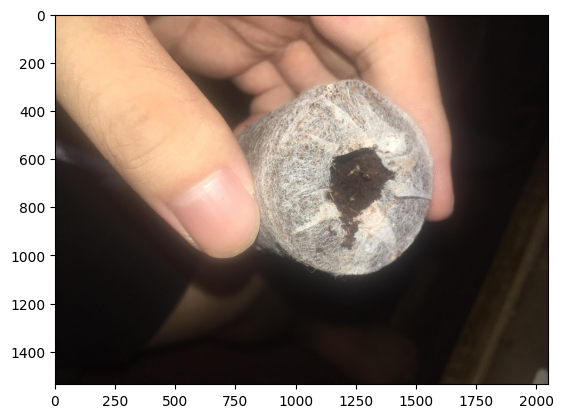

In [ ]:
plt.imshow(img)

In [ ]:
a = torch.from_numpy(img).permute(1, 2, 0)
a = a.to(next(resnet.parameters()).device)

In [ ]:
resnet.cpu()
resnet(a.unsqueeze(0))